In diesem Notebook wird das Alter von Personen durch deren jeweiligen MRT-Hirnscan durch Deep Learning vorhergesagt.
Dieses vorhergesagte "BrainAge" kann als Biomarker verwendet werden, da ein erhöhtes BrainAge (> tatsächliches Alter) mit psychiatrischen Krankheiten assoziert werden kann.

Da MRT-Scans dreidimensionale Bilddaten sind, wird ein 3D [CNN](https://de.wikipedia.org/wiki/Convolutional_Neural_Network) zur Vorhersage des BrainAge verwendet

<img src="machine_learning_pipeline.png" style="width:800px;height:300px;">

Es wird Version 1 von [fastai](https://fastai1.fast.ai/) (Installationsanleitung inkl. PyTorch im Link) verwendet.

Packages werden importiert

In [1]:
import fastai_scans
from fastai.basics import *


Die öffentlich verfügbaren MRT-Scans aus dem [IXI-Datensatz](https://brain-development.org/ixi-dataset/) wurde bereits vorverarbeitet. Schädelknochen wurde rausgeschnitten und die Auflösung wurde reduziert um die Analyse zu beschleunigen

In [3]:
brains_path = '../data/brains_IXI'
targets_path = '../data/targets.csv'
data = (fastai_scans.VolumeItemList.from_paths(Path(brains_path), Path(targets_path))
                                   .split_by_rand_pct(0.2, seed=7) # 20% der Daten als Validierungsdatensatz
                                   .label_from_metadata('age_centuries') # Alter / 100 wird vorhergesagt
                                   .transform(fastai_scans.get_transforms()) # Data Augmentation
                                   .databunch(bs=32) # Batch Size
                                   .normalize()) # Normalisiert die Intensität der Voxel (3D Pixel)
data.show_batch(2)

/home/lfisch/.conda/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Als Modell wird ein [Resnet](https://arxiv.org/abs/1512.03385) mit 3D Kernel verwendet.

Daten und Modell werden in ein [Learner](https://fastai1.fast.ai/basic_train.html#Learner) zusammengefasst.

In [5]:
resolution = (34, 42, 34)
model = fastai_scans.models.ResNet3d(resolution, num_blocks=[1], num_classes=1)
learn = Learner(data, model, metrics=[mean_absolute_error])
print(learn.summary())

Durch [.lr_find](https://fastai1.fast.ai/callbacks.lr_finder.html#lr_find) wird eine gute Learning Rate wird bestimmt.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.55E-05
Min loss divided by 10: 1.58E-02


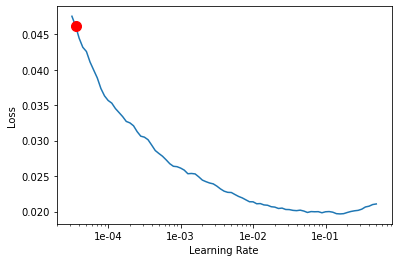

In [6]:
learn.lr_find(start_lr=1e-05, end_lr=1)
learn.recorder.plot(suggestion=True)

Durch [.fit_one_cycle](https://fastai1.fast.ai/train.html#fit_one_cycle) wird mit einer zyklischen Learning Rate gefittet.

In [7]:
learn.fit_one_cycle(50, 1e-2)
print(f'MAE in the validation dataset: {learn.recorder.metrics[-1][-1].item() * 100:.2f} years')

epoch,train_loss,valid_loss,mean_absolute_error,time
0,0.022105,0.034897,0.154716,00:00
1,0.019710,0.047679,0.179131,00:00
2,0.018147,0.040915,0.172337,00:00
3,0.016892,0.026125,0.135302,00:00
4,0.015951,0.023061,0.121298,00:00
5,0.015041,0.033904,0.157379,00:00
6,0.014455,0.212936,0.439140,00:00
7,0.014480,0.070838,0.243848,00:00
8,0.014091,0.044435,0.182596,00:00
9,0.013785,0.026179,0.139236,00:00


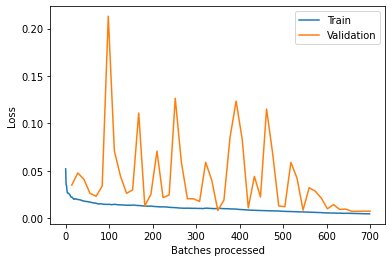

In [8]:
learn.recorder.plot_losses()

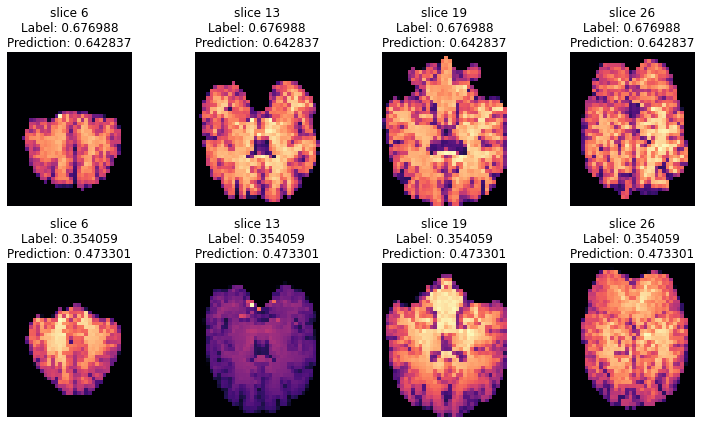

In [9]:
learn.show_results(rows=2)